## 1. 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import pickle

from tqdm import tqdm
from sklearn.cluster import KMeans
from PIL import Image

## 2. 데이터 불러오기

#### 메타데이터

In [2]:
dpath = 'data/' # 데이터 경로 설정
data = pd.read_csv(dpath + 'metadata.csv')
data

,album_id,album_name,artist,album_release_date,album_total_tracks,emotion,playlist_name
0,0025Y5D7IOZVpEfQtpvHIi,Into the Surf,Foals,2019-09-25,3,relaxed,calm winter morning ☆☆
1,002hMu6uJDan1XKVp3pmnb,Becoming,Feather,2021-01-13,5,sad,Sad Beats
2,002mOl8os2F1mDYRz8qU2a,Антигерой,ELMAN,2019-06-06,1,sad,슬픔
3,004EYz2DQttcGvyTQGDmLp,Merry Christmas Baby / White Christmas,Otis Redding,1968,2,happy,Happy Holidays
4,005KGm28jIUE3hW019Itx6,Too Much Love,Mujo,2021-04-15,1,relaxed,"Chill Beats 💙 groove, relax"
...,...,...,...,...,...,...,...
63309,7zw73YMhMg7lnMrkUAzE8t,Just Another Memory,JustSidekicks,2020-07-10,1,happy,Happy Vibes ?��
63310,7zwLfr8xSz9rWPU5KNBHkQ,cherry,Oatmello,2019-05-24,1,relaxed,Relax Lofi 😴
63311,7zxLuEY7mKLKdyWjnCfP35,Colorblind (feat. Dayseeker),Adventure Club,2021-08-13,1,sad,Sad Beats
63312,7zxfQk44mX0eW4eWtdDlKI,Mind Right,TK N Cash,2014-10-14,1,angry,Pissed Off Workout


## 대표색추출기반 추천시스템 프로세스
**Kmeans 기반으로 추출한 대표색 5개와 그 비중을 토대로 최종 거리 계산**

1) 대표색끼리 유클리디안 거리를 계산하여 가장 작은 거리를 가지는 대표색 각각의 비중과 그 거리를 곱하여 더해나감

2) 선택된 대표색은 빼고, 5번 반복하여 최종 거리가 계산됨

3) input이미지와 모든 이미지에 대해 비교하여 최저 N개를 뽑음

## 3-1. 사전에 수집된 이미지의 인덱스를 입력받아 추천하는 시스템 

참고: https://inyl.github.io/programming/2017/07/31/opencv_image_color_cluster.html

In [3]:
# 대표색의 비중을 반환하는 함수
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

In [4]:
# input index와 감정을 입력받아 n개의 추천 이미지 인덱스를 반환하는 함수
def recommend_by_idx(input_idx, sentiment='relaxed', n=15):
    
    # 이미지 불러오기
    image_list = []
    image_array_list = []
    na_id = []
    album_ids = data[data['emotion'] == sentiment]['album_id']

    for album_id in tqdm(album_ids):
        image_list.append(Image.open(dpath + "emotion_album_images/{}/{}.jpg".format(sentiment, album_id)).resize((300,300)))
        image_array_list.append(np.array(image_list[-1]))
        
    
    # 각 이미지의 center와 hist 정보가 저장되어있는 파일 불러오기
    with open('{}_center.pickle'.format(sentiment), 'rb') as f:
        center = pickle.load(f)
    with open('{}_hist.pickle'.format(sentiment), 'rb') as f:
        hist = pickle.load(f)
        
        
    # 이미지가 그냥 흰색이거나 검은색이어서 5개의 대표색이 추출되지 않은 이미지 인덱스
    if sentiment == 'happy':
        except_list = [619, 6005, 8299]
    elif sentiment == 'angry':
        except_list = [202, 470, 525, 1138, 2784, 2994, 4283, 4672, 5005, 5262, 
                       5322, 7244, 7747, 7760, 7780, 8834, 9880, 10414, 11883, 11967] 
    elif sentiment == 'relaxed':
        except_list = [4994, 7526, 7721, 7999, 10672, 13064, 15070]
    elif sentiment == 'sad':
        except_list = [595, 977, 3806, 4266, 5933, 8157, 8688, 8754, 9488, 10033, 11595, 11984]

        
    # 비중이 높은 순으로 정렬
    for i in range(len(center)):
        hist[i] = hist[i][list(np.argsort(-hist[i]))]
        center[i] = center[i][list(np.argsort(-hist[i]))]
        
    
    # 거리 계산
    dist_list = []
    for i in range(len(center)):

        if i in except_list:
            dist_list.append(np.nan)
            continue

        dist = 0
        temp_mat = np.asmatrix(np.ndarray((5,5)))
        for c1 in range(5):
            for c2 in range(5):
                temp_mat[c1, c2] = np.linalg.norm(np.array(center[input_idx][c1]) - np.array(center[i][c2]))

        for j in range(5):
            i1, i2 = np.unravel_index(temp_mat.argmin(), temp_mat.shape)
            dist += temp_mat[i1, i2] * hist[input_idx][i1] * hist[i][i2]
            temp_mat = np.delete(temp_mat, obj=i1, axis=0)
            temp_mat = np.delete(temp_mat, obj=i2, axis=1)

        dist_list.append(dist)
    
    indices = list(np.argsort(dist_list)[1:n+1])
        
    # 이미지로 결과 확인하기
    plt.figure(figsize=(10,5))
    plt.subplot(2, 5, 1)
    plt.imshow(image_list[input_idx])
    plt.axis('off')

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+6)
        plt.imshow(image_list[idx])
        plt.axis('off')
        
    return indices

**결과**

100%|████████████████████████████████████████████████████████████████████████████| 19614/19614 [04:49<00:00, 67.65it/s]


[17278, 3820, 2536, 13403, 11066]

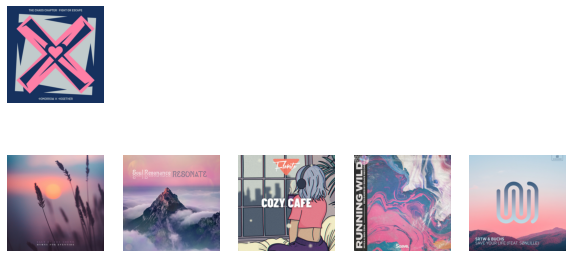

In [5]:
SENT = 'relaxed'
INPUT = 5555

indices = recommend_by_idx(INPUT, sentiment=SENT, n=5)
indices

In [6]:
# 데이터프레임으로 결과 확인
album_ids = data[data['emotion'] == SENT]['album_id']

result = pd.DataFrame()
for val in album_ids.iloc[indices].values:
    result = pd.concat([result, data[data['album_id'] == val]], axis=0)

result = result.drop_duplicates(['album_id'])    
result[['album_name', 'artist', 'album_release_date']]

,album_name,artist,album_release_date
55856,Hymns for Eventide (Eventide Mix),Salt Of The Sound,2021-04-01
12373,Resonate,Soul Resonance,2020-05-13
8153,Cozy Cafe,Florito,2021-03-26
43259,Running Wild,MVCA,2020-07-24
35642,Save Your Life,SRTW,2021-02-19


## 3-2. 기존에 없던 새로운 이미지를 입력받아 추천하는 함수 구현

In [7]:
# input image와 감정을 입력받아 n개의 추천 이미지 인덱스를 반환하는 함수
def recommend_by_new(my_image, sentiment='relaxed', n=5):
    
    # 기존 이미지 불러오기
    image_list = []
    image_array_list = []
    na_id = []
    album_ids = data[data['emotion'] == sentiment]['album_id']

    for album_id in tqdm(album_ids):
        image_list.append(Image.open(dpath + "emotion_album_images/{}/{}.jpg".format(sentiment, album_id)).resize((300,300)))
        image_array_list.append(np.array(image_list[-1]))
        
    
    # 각 이미지의 center와 hist 정보가 저장되어있는 파일 불러오기
    with open('{}_center.pickle'.format(sentiment), 'rb') as f:
        center = pickle.load(f)
    with open('{}_hist.pickle'.format(sentiment), 'rb') as f:
        hist = pickle.load(f)
        
        
    # 이미지가 그냥 흰색이거나 검은색이어서 5개의 대표색이 추출되지 않은 이미지 인덱스
    if sentiment == 'happy':
        except_list = [619, 6005, 8299]
    elif sentiment == 'angry':
        except_list = [202, 470, 525, 1138, 2784, 2994, 4283, 4672, 5005, 5262, 
                       5322, 7244, 7747, 7760, 7780, 8834, 9880, 10414, 11883, 11967] 
    elif sentiment == 'relaxed':
        except_list = [4994, 7526, 7721, 7999, 10672, 13064, 15070]
    elif sentiment == 'sad':
        except_list = [595, 977, 3806, 4266, 5933, 8157, 8688, 8754, 9488, 10033, 11595, 11984]

        
    # 비중이 높은 순으로 정렬
    for i in range(len(center)):
        hist[i] = hist[i][list(np.argsort(-hist[i]))]
        center[i] = center[i][list(np.argsort(-hist[i]))]
        
        
    # 입력 이미지 불러오기 & kmeans 적용
    image_array = np.array(my_image)
    temp_image = image_array.reshape((-1, 3))
    clt = KMeans(n_clusters = 5)
    clt.fit(temp_image)
    
    input_center = clt.cluster_centers_
    input_hist = centroid_histogram(clt)
    
    
    # 거리 계산
    dist_list = []
    for i in range(len(center)):

        if i in except_list:
            dist_list.append(np.nan)
            continue

        dist = 0
        temp_mat = np.asmatrix(np.ndarray((5,5)))
        for c1 in range(5):
            for c2 in range(5):
                temp_mat[c1, c2] = np.linalg.norm(np.array(input_center[c1]) - np.array(center[i][c2]))

        for j in range(5):
            i1, i2 = np.unravel_index(temp_mat.argmin(), temp_mat.shape)
            dist += temp_mat[i1, i2] * input_hist[i1] * hist[i][i2]
            temp_mat = np.delete(temp_mat, obj=i1, axis=0)
            temp_mat = np.delete(temp_mat, obj=i2, axis=1)

        dist_list.append(dist)
        
    indices = list(np.argsort(dist_list)[:n])
        
    # 이미지로 결과 확인하기
    plt.figure(figsize=(10,5))
    plt.subplot(2, 5, 1)
    plt.imshow(my_image)
    plt.axis('off')

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+6)
        plt.imshow(image_list[idx])
        plt.axis('off')
        
    return indices

**결과**

100%|████████████████████████████████████████████████████████████████████████████| 19614/19614 [04:31<00:00, 72.27it/s]


[7559, 8246, 6119, 14751, 16247]

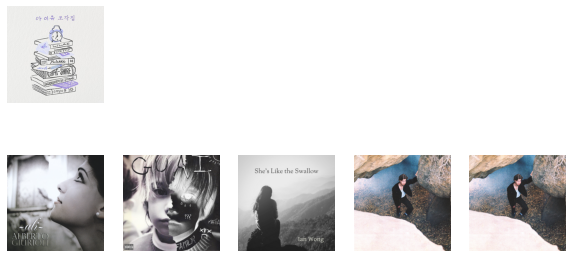

In [8]:
image_path = 'data/new_image.jpg'
my_image = Image.open(image_path).resize((300,300))
SENT = 'relaxed'

indices = recommend_by_new(my_image, sentiment=SENT, n=5)
indices

In [9]:
# 데이터프레임으로 결과 확인
album_ids = data[data['emotion'] == SENT]['album_id']

result = pd.DataFrame()
for val in album_ids.iloc[indices].values:
    result = pd.concat([result, data[data['album_id'] == val]], axis=0)

result = result.drop_duplicates(['album_id'])    
result[['album_name', 'artist', 'album_release_date']]

,album_name,artist,album_release_date
24391,Ali,Alberto Giurioli,2011-12-03
26662,GUAI,Mandark,2020-01-08
19666,She's Like the Swallow,Ian Wong,2017-11-24
47673,Casanova,Blake Rose,2021-08-06
52546,A World Gone By,Blake Rose,2021-10-08


100%|████████████████████████████████████████████████████████████████████████████| 15403/15403 [03:55<00:00, 65.51it/s]


[11839, 11222, 5812, 10572, 8756]

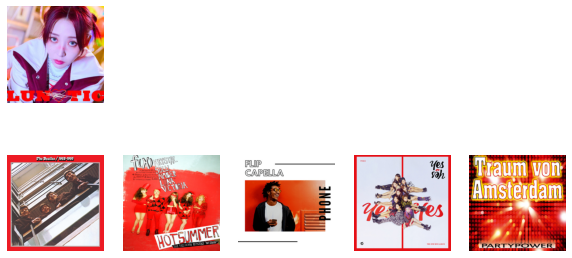

In [10]:
image_path = 'data/new_image2.jpg'
my_image = Image.open(image_path).resize((300,300))
SENT = 'happy'

indices = recommend_by_new(my_image, sentiment=SENT, n=5)
indices

In [11]:
# 데이터프레임으로 결과 확인
album_ids = data[data['emotion'] == SENT]['album_id']

result = pd.DataFrame()
for val in album_ids.iloc[indices].values:
    result = pd.concat([result, data[data['album_id'] == val]], axis=0)

result = result.drop_duplicates(['album_id'])    
result[['album_name', 'artist', 'album_release_date']]

,album_name,artist,album_release_date
48844,The Beatles 1962 - 1966 (Remastered),The Beatles,1973-04-01
46364,Hot Summer - The 1st Album Repackage,f(x),2011-06-14
24076,Phone,Flip Capella,2020-10-02
43537,YES or YES,TWICE,2018-11-05
36342,Traum von Amsterdam,Partypower,2012-04-10
